In [145]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import ast
import IPython
from sklearn.model_selection import GridSearchCV
from IPython.display import Audio, display
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

**importing features from preprocessing notebook**

In [146]:
df = pd.read_csv('../../dataset/features.csv')

print(df.head(1))  
print('------------------------------------------------')
print(df.columns)  
print('------------------------------------------------')
print(df.dtypes)   

  Gender  Age Emotion Emotion levels  \
0   Male   51     ANG             XX   

                                     Location  \
0  ../../dataset/AudioWAV/1001_DFA_ANG_XX.wav   

                                           mfcc_mean  \
0  [-341.9889221191406, 120.79996490478516, -9.83...   

                                     mfcc_delta_mean  \
0  [0.6921295523643494, 0.4810692071914673, 0.032...   

                                    mfcc_delta2_mean  \
0  [-0.6971630454063416, -0.4661799669265747, -0....   

                                    mel_spec_db_mean  spectral_centroid_mean  \
0  [-54.73905563354492, -48.92445373535156, -41.5...             1516.157973   

   zcr_mean  
0  0.080581  
------------------------------------------------
Index(['Gender', 'Age', 'Emotion', 'Emotion levels', 'Location', 'mfcc_mean',
       'mfcc_delta_mean', 'mfcc_delta2_mean', 'mel_spec_db_mean',
       'spectral_centroid_mean', 'zcr_mean'],
      dtype='object')
-------------------------------

In [147]:
print('na values\n', df.isna().sum())
print('------------------------------------------------')
print("number of duplicated values:\n", df.duplicated().sum())
print('------------------------------------------------')
print("shape:\n", df.shape)

na values
 Gender                    0
Age                       0
Emotion                   0
Emotion levels            0
Location                  0
mfcc_mean                 0
mfcc_delta_mean           0
mfcc_delta2_mean          0
mel_spec_db_mean          0
spectral_centroid_mean    0
zcr_mean                  0
dtype: int64
------------------------------------------------
number of duplicated values:
 0
------------------------------------------------
shape:
 (7442, 11)


In [148]:
print('Emotion level value counts\n', df['Emotion levels'].value_counts())

#dropping where emotion level is x
idx = df[df['Emotion levels'] == "X"].index
print(idx)

df = df.drop(idx)

Emotion level value counts
 Emotion levels
XX    6076
HI     455
LO     455
MD     455
X        1
Name: count, dtype: int64
Index([3212], dtype='int64')


In [149]:
df['Emotion levels'].value_counts()

#Currently, the data will remain unbalanced; later, emotion levels will be categorized as specified/unspecified

Emotion levels
XX    6076
HI     455
LO     455
MD     455
Name: count, dtype: int64

In [150]:
df['Emotion'].value_counts()

#it can be concluded that the data is approximately evenly distributed

Emotion
ANG    1271
DIS    1271
FEA    1271
HAP    1271
SAD    1270
NEU    1087
Name: count, dtype: int64

**encoding**

In [151]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

df = pd.get_dummies(df, columns=['Emotion levels'], drop_first=True)
dummy_cols = [col for col in df.columns if col.startswith('Emotion levels_')]
df[dummy_cols] = df[dummy_cols].astype(int)

emotion_mapping = {
    'ANG': 0,
    'DIS': 1,
    'FEA': 2,
    'HAP': 3,
    'SAD': 4,
    'NEU': 5
}

df['emotion_numeric'] = df['Emotion'].map(emotion_mapping)


print(df.head())


   Gender  Age Emotion                                    Location  \
0       1   51     ANG  ../../dataset/AudioWAV/1001_DFA_ANG_XX.wav   
1       1   51     DIS  ../../dataset/AudioWAV/1001_DFA_DIS_XX.wav   
2       1   51     FEA  ../../dataset/AudioWAV/1001_DFA_FEA_XX.wav   
3       1   51     HAP  ../../dataset/AudioWAV/1001_DFA_HAP_XX.wav   
4       1   51     NEU  ../../dataset/AudioWAV/1001_DFA_NEU_XX.wav   

                                           mfcc_mean  \
0  [-341.9889221191406, 120.79996490478516, -9.83...   
1  [-388.4619445800781, 133.88211059570312, -17.7...   
2  [-352.20843505859375, 115.79106903076172, -3.4...   
3  [-337.8395690917969, 120.10960388183594, -12.6...   
4  [-368.1755676269531, 124.36493682861328, -4.64...   

                                     mfcc_delta_mean  \
0  [0.6921295523643494, 0.4810692071914673, 0.032...   
1  [0.08185644447803497, 0.11408255249261856, -0....   
2  [-0.008709535002708435, -0.020871829241514206,...   
3  [-0.06729506701

In [153]:
print(df.loc[1])

Gender                                                                    1
Age                                                                      51
Emotion                                                                 DIS
Location                         ../../dataset/AudioWAV/1001_DFA_DIS_XX.wav
mfcc_mean                 [-388.4619445800781, 133.88211059570312, -17.7...
mfcc_delta_mean           [0.08185644447803497, 0.11408255249261856, -0....
mfcc_delta2_mean          [-0.18879133462905884, -0.041042305529117584, ...
mel_spec_db_mean          [-44.846012115478516, -38.46656799316406, -29....
spectral_centroid_mean                                          1457.589671
zcr_mean                                                           0.069094
Emotion levels_LO                                                         0
Emotion levels_MD                                                         0
Emotion levels_XX                                                         1
emotion_nume

In [154]:
#dropping the 'emotion' column, since we included dummy variables
df = df.drop(columns=['Emotion'])

In [155]:
print(df.dtypes)

Gender                      int64
Age                         int64
Location                   object
mfcc_mean                  object
mfcc_delta_mean            object
mfcc_delta2_mean           object
mel_spec_db_mean           object
spectral_centroid_mean    float64
zcr_mean                  float64
Emotion levels_LO           int64
Emotion levels_MD           int64
Emotion levels_XX           int64
emotion_numeric             int64
dtype: object


In [156]:
#expanding columns that contain lists as values
list_columns = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mel_spec_db_mean']

for col in list_columns:
    if col not in df.columns:
        print(f"skipping {col}, not found")
        continue
    
    print(f"\nworking on: {col}")
    
    # sting -> list
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # num -> list (if num is somewhere)
    df[col] = df[col].apply(lambda x: [x] if isinstance(x, (float, int)) else x)
        
    # max list lenght in the column
    max_len = df[col].apply(len).max()
    
    # filling lists with zeros if neccessary
    df[col] = df[col].apply(lambda x: x + [0]*(max_len - len(x)))
    
    #expanding the df
    expanded = pd.DataFrame(df[col].tolist(), index=df.index)
    expanded.columns = [f'{col}_{i}' for i in range(max_len)]
    
    #dropping org columns
    df = df.drop(columns=[col])
    df = pd.concat([df, expanded], axis=1)
    
    print(f"expanding {max_len} new columns.")

print("\nall columns edited properly")



working on: mfcc_mean
expanding 20 new columns.

working on: mfcc_delta_mean
expanding 20 new columns.

working on: mfcc_delta2_mean
expanding 20 new columns.

working on: mel_spec_db_mean
expanding 128 new columns.

all columns edited properly


In [157]:
print(df.loc[0])

Gender                                                             1
Age                                                               51
Location                  ../../dataset/AudioWAV/1001_DFA_ANG_XX.wav
spectral_centroid_mean                                   1516.157973
zcr_mean                                                    0.080581
                                             ...                    
mel_spec_db_mean_123                                           -80.0
mel_spec_db_mean_124                                           -80.0
mel_spec_db_mean_125                                           -80.0
mel_spec_db_mean_126                                           -80.0
mel_spec_db_mean_127                                           -80.0
Name: 0, Length: 197, dtype: object


In [158]:
print(df.dtypes)

Gender                      int64
Age                         int64
Location                   object
spectral_centroid_mean    float64
zcr_mean                  float64
                           ...   
mel_spec_db_mean_123      float64
mel_spec_db_mean_124      float64
mel_spec_db_mean_125      float64
mel_spec_db_mean_126      float64
mel_spec_db_mean_127      float64
Length: 197, dtype: object


Standardization

In [159]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

#numeric_cols will be predicted -> no standardization
numeric_cols = numeric_cols.drop('emotion_numeric') if 'emotion_numeric' in numeric_cols else numeric_cols

print("cols for standardization:", list(numeric_cols))

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("\ndata after the standardization process:")
print(df[numeric_cols].head())

cols for standardization: ['Gender', 'Age', 'spectral_centroid_mean', 'zcr_mean', 'Emotion levels_LO', 'Emotion levels_MD', 'Emotion levels_XX', 'mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12', 'mfcc_mean_13', 'mfcc_mean_14', 'mfcc_mean_15', 'mfcc_mean_16', 'mfcc_mean_17', 'mfcc_mean_18', 'mfcc_mean_19', 'mfcc_delta_mean_0', 'mfcc_delta_mean_1', 'mfcc_delta_mean_2', 'mfcc_delta_mean_3', 'mfcc_delta_mean_4', 'mfcc_delta_mean_5', 'mfcc_delta_mean_6', 'mfcc_delta_mean_7', 'mfcc_delta_mean_8', 'mfcc_delta_mean_9', 'mfcc_delta_mean_10', 'mfcc_delta_mean_11', 'mfcc_delta_mean_12', 'mfcc_delta_mean_13', 'mfcc_delta_mean_14', 'mfcc_delta_mean_15', 'mfcc_delta_mean_16', 'mfcc_delta_mean_17', 'mfcc_delta_mean_18', 'mfcc_delta_mean_19', 'mfcc_delta2_mean_0', 'mfcc_delta2_mean_1', 'mfcc_delta2_mean_2', 'mfcc_delta2_mean_3', 'mfcc_delta2_mean_4', 'mfcc

In [160]:
print(df.loc[0])

Gender                                                      0.945445
Age                                                         1.102698
Location                  ../../dataset/AudioWAV/1001_DFA_ANG_XX.wav
spectral_centroid_mean                                      0.491062
zcr_mean                                                    0.725741
                                             ...                    
mel_spec_db_mean_123                                       -0.029498
mel_spec_db_mean_124                                       -0.029116
mel_spec_db_mean_125                                       -0.028836
mel_spec_db_mean_126                                       -0.028654
mel_spec_db_mean_127                                       -0.028541
Name: 0, Length: 197, dtype: object


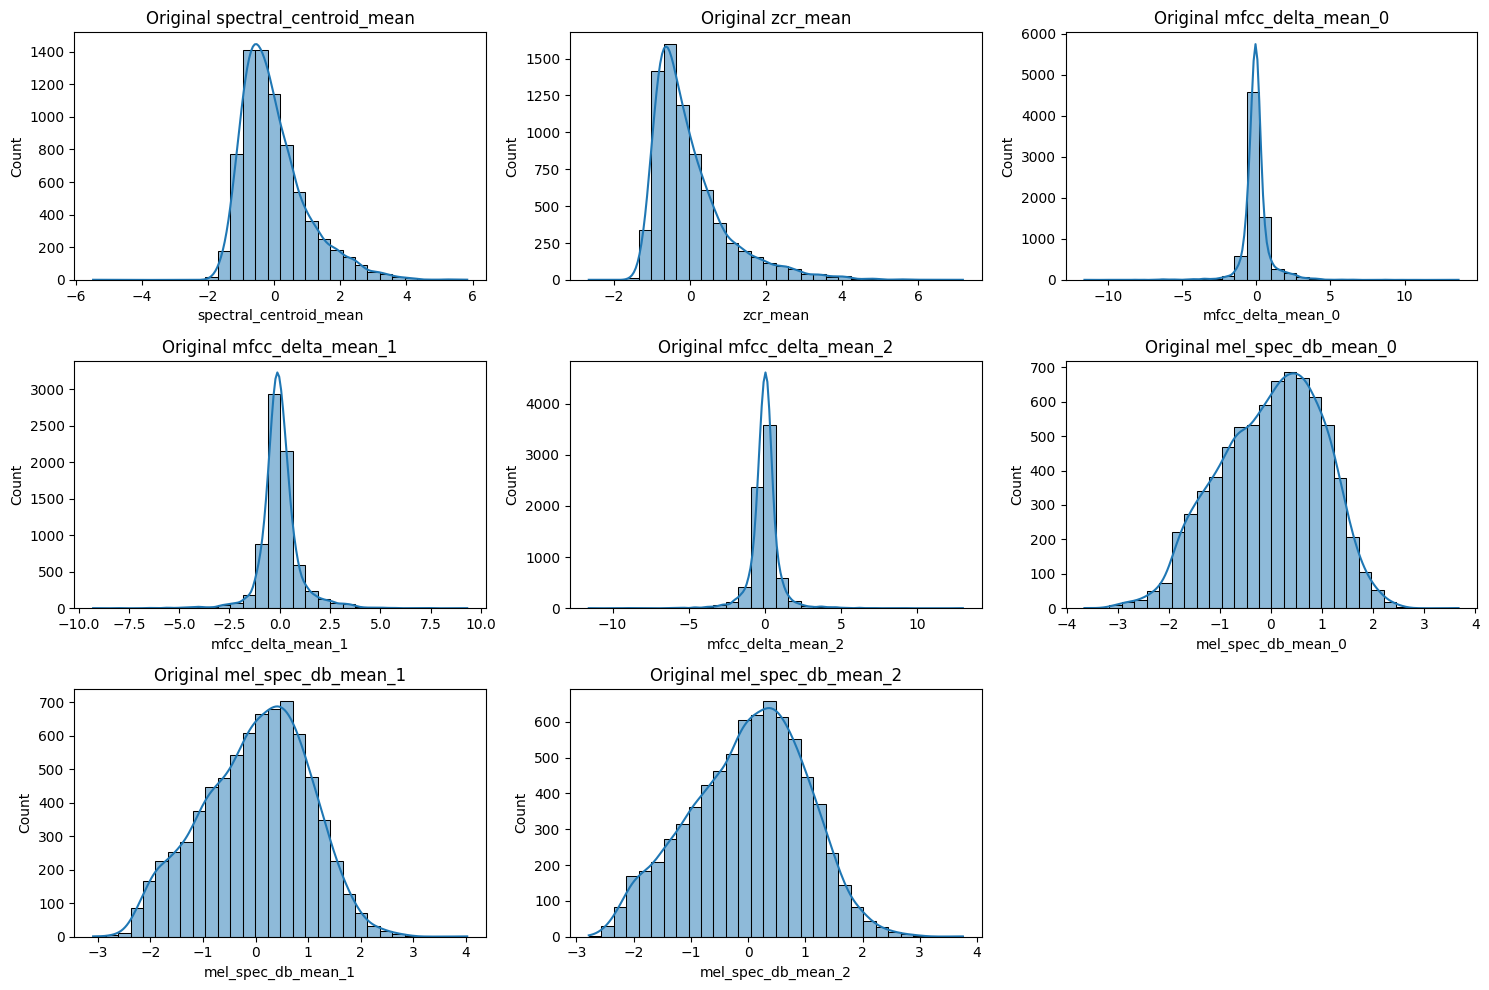

In [161]:
feature_cols = ['spectral_centroid_mean', 'zcr_mean'] + \
               [f'mfcc_delta_mean_{i}' for i in range(3)] + \
               [f'mel_spec_db_mean_{i}' for i in range(3)]

plt.figure(figsize=(15, 10))
for i, col in enumerate(feature_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Original {col}')
plt.tight_layout()
plt.show()

In [162]:
#unnecessary column 'location'
df = df.drop(columns=['Location'])

In [163]:
X = df.drop(columns=['emotion_numeric'])
y = df['emotion_numeric']

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200, 220, 250, 270, 300, 305, 310, 320],
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))


#Best parameters: {'n_estimators': 310}
#Best cross-validation score: 0.4450619139343395
#Test Accuracy: 0.4432505036937542

Best parameters: {'n_estimators': 310}
Best cross-validation score: 0.4450619139343395
Test Accuracy: 0.4432505036937542


In [165]:
# Random Forest
rf1 = RandomForestClassifier(n_estimators=310, random_state=42)
rf1.fit(X_train, y_train)

# Evaluation
y_pred = rf1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4432505036937542

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.71      0.65       254
           1       0.42      0.27      0.33       254
           2       0.37      0.22      0.28       255
           3       0.36      0.37      0.37       254
           4       0.47      0.63      0.54       254
           5       0.37      0.45      0.41       218

    accuracy                           0.44      1489
   macro avg       0.43      0.44      0.43      1489
weighted avg       0.43      0.44      0.43      1489



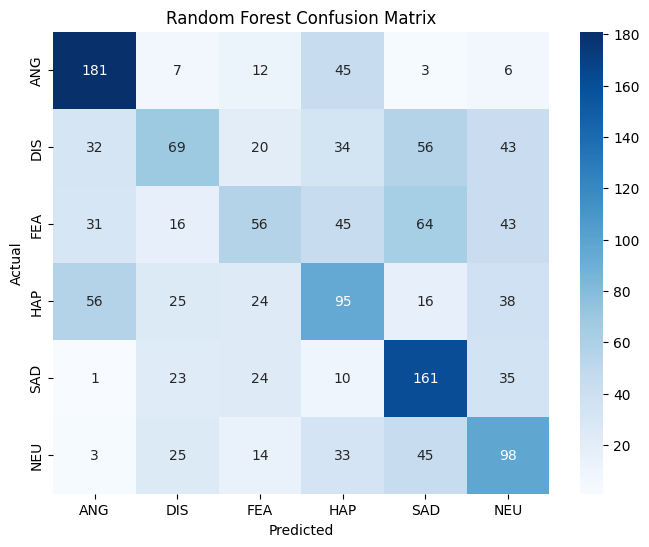

In [166]:
cmrf1 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cmrf1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [167]:
nb_model1 = GaussianNB()
nb_model1.fit(X_train, y_train)

y_pred = nb_model1.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("classification report:\n", classification_report(y_test, y_pred))

accuracy: 0.3109469442578912
classification report:
               precision    recall  f1-score   support

           0       0.36      0.70      0.47       254
           1       0.22      0.06      0.09       254
           2       0.20      0.00      0.01       255
           3       0.37      0.10      0.16       254
           4       0.44      0.26      0.33       254
           5       0.25      0.82      0.39       218

    accuracy                           0.31      1489
   macro avg       0.31      0.32      0.24      1489
weighted avg       0.31      0.31      0.24      1489



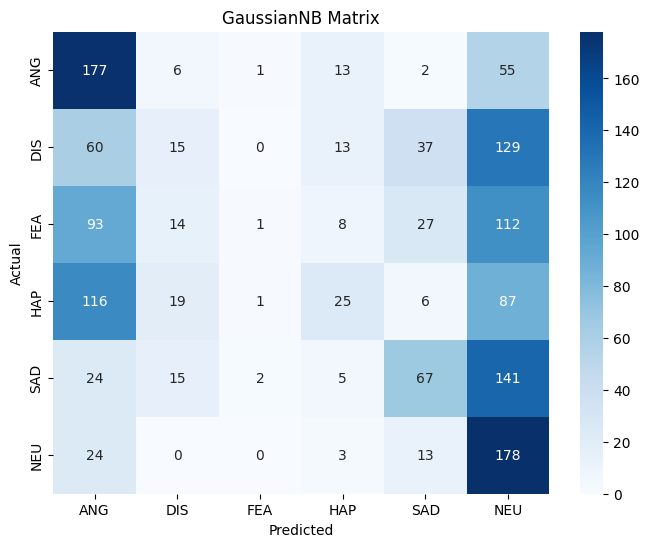

In [168]:
cmnb1 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cmnb1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("GaussianNB Matrix")
plt.show()

c:\Users\milic\OneDrive\Radna površina\faksic\IV_godinica\ML\voice_emotion_recognition\voice_emotion_recognition\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2582 - loss: 1.7753 - val_accuracy: 0.3915 - val_loss: 1.5096
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3626 - loss: 1.5466 - val_accuracy: 0.4016 - val_loss: 1.4621
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3818 - loss: 1.4860 - val_accuracy: 0.4083 - val_loss: 1.4392
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3892 - loss: 1.4453 - val_accuracy: 0.4244 - val_loss: 1.4178
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4114 - loss: 1.4239 - val_accuracy: 0.4359 - val_loss: 1.4037
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4323 - loss: 1.3927 - val_accuracy: 0.4278 - val_loss: 1.3920
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4385 - loss: 1.3806 - val_accuracy: 0.4459 - val_loss: 1.3870
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4425 - loss: 1.3586 - val_accuracy: 0.

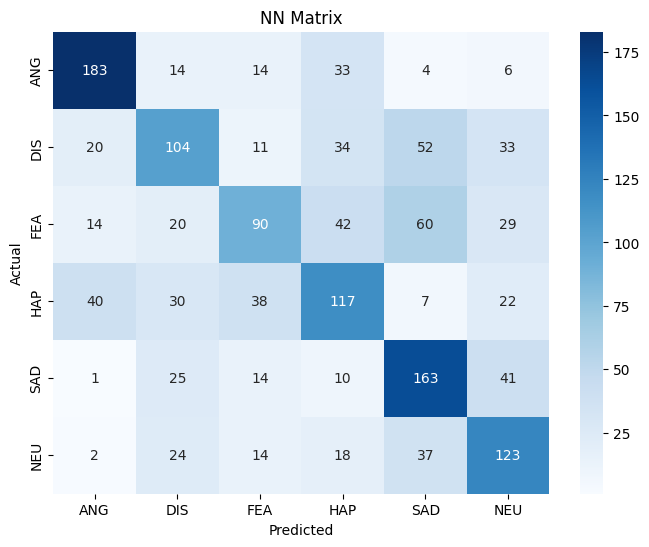

In [169]:
input_dim = X_train.shape[1]  

model1 = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  
])


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model1.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=50, batch_size=32, callbacks=[early_stop],
          class_weight=class_weights)


history = model1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nclassification report:\n")
print(classification_report(y_test, y_pred_classes))


cmnn1 = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cmnn1, annot=True, fmt="d", cmap="Blues",
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("NN Matrix")
plt.show()


Best parameters: {'C': 15, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.48437892033387664
Test Accuracy: 0.5023505708529215
              precision    recall  f1-score   support

           0       0.70      0.73      0.71       254
           1       0.40      0.39      0.40       254
           2       0.46      0.39      0.42       255
           3       0.51      0.44      0.47       254
           4       0.49      0.56      0.52       254
           5       0.44      0.50      0.47       218

    accuracy                           0.50      1489
   macro avg       0.50      0.50      0.50      1489
weighted avg       0.50      0.50      0.50      1489



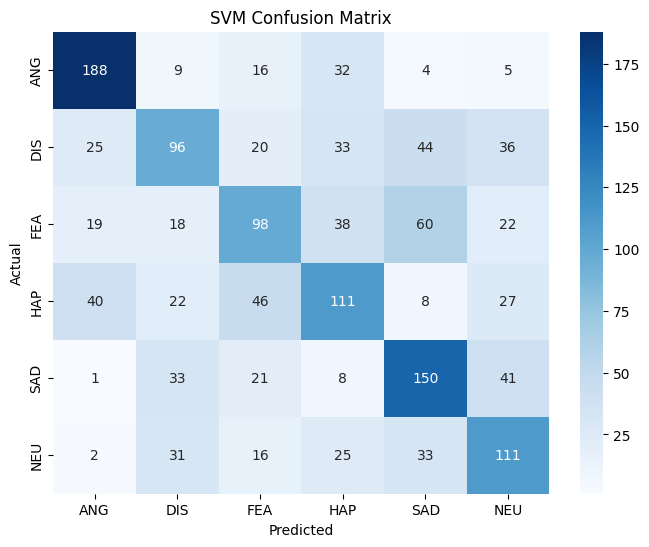

In [ ]:
param_grid = {
    'C': [0.1, 1, 5, 10, 15],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']  
}

svc = SVC()

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_svc = grid_search.best_estimator_
y_pred_svm = best_svc.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

cmsvc1 = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cmsvc1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()


#Best parameters: {'C': 15, 'gamma': 0.001, 'kernel': 'rbf'}
#Best cross-validation score: 0.48437892033387664
#Test Accuracy: 0.5023505708529215

Accuracy: 0.5023505708529215
              precision    recall  f1-score   support

           0       0.70      0.73      0.71       254
           1       0.40      0.39      0.40       254
           2       0.46      0.39      0.42       255
           3       0.51      0.44      0.47       254
           4       0.49      0.56      0.52       254
           5       0.44      0.50      0.47       218

    accuracy                           0.50      1489
   macro avg       0.50      0.50      0.50      1489
weighted avg       0.50      0.50      0.50      1489



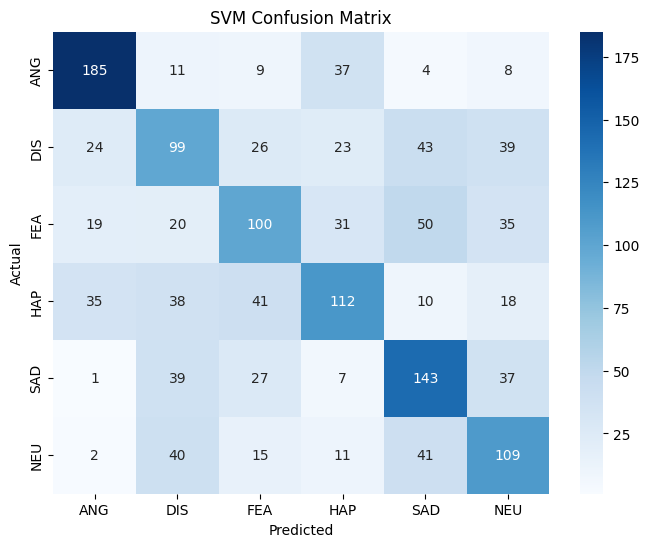

In [170]:
svm_model1 = SVC(kernel='rbf', C=15, gamma=0.001)
svm_model1.fit(X_train, y_train)

y_pred_svm = svm_model1.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

cmsvc1 = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cmsvc1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

accuraccy LDA: 0.47750167897918067
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       254
           1       0.39      0.37      0.38       254
           2       0.38      0.35      0.37       255
           3       0.43      0.42      0.43       254
           4       0.52      0.59      0.55       254
           5       0.40      0.42      0.41       218

    accuracy                           0.48      1489
   macro avg       0.47      0.48      0.47      1489
weighted avg       0.48      0.48      0.48      1489



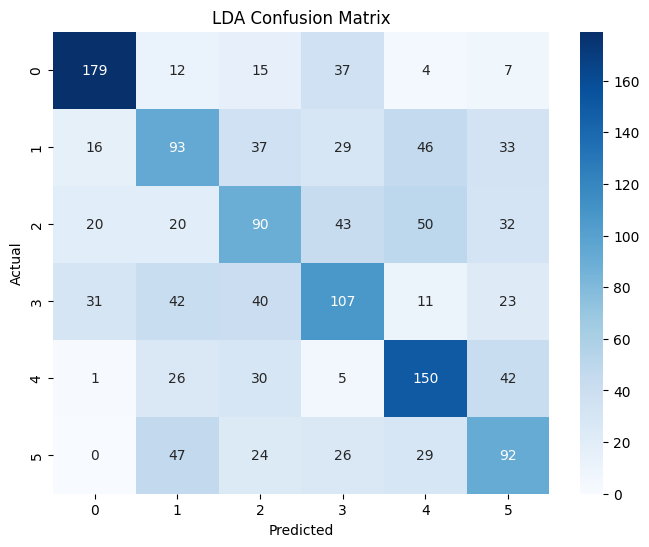

In [171]:
lda_model1 = LinearDiscriminantAnalysis()
lda_model1.fit(X_train, y_train)

y_pred_lda = lda_model1.predict(X_test)

print("accuraccy LDA:", accuracy_score(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda))

cmlda1 = confusion_matrix(y_test, y_pred_lda)
plt.figure(figsize=(8,6))
sns.heatmap(cmlda1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LDA Confusion Matrix')
plt.show()


In the next segment, different data will be used — columns where the values were lists will be modified so that their value is the average of the list, as there is a possibility that dimensionality affects the model’s results. Models of the same architecture will be trained on such data, and then I will attempt to find the optimal parameters.

In [172]:
df = pd.read_csv('../../dataset/features.csv')

idx = df[df['Emotion levels'] == "X"].index
print(idx)

df = df.drop(idx)

Index([3212], dtype='int64')


In [173]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
df = pd.get_dummies(df, columns=['Emotion levels'], drop_first=True)
dummy_cols = [col for col in df.columns if col.startswith('Emotion levels_')]

df[dummy_cols] = df[dummy_cols].astype(int)


emotion_mapping = {
    'ANG': 0,
    'DIS': 1,
    'FEA': 2,
    'HAP': 3,
    'SAD': 4,
    'NEU': 5
}

df['emotion_numeric'] = df['Emotion'].map(emotion_mapping)


print(df.head())

   Gender  Age Emotion                                    Location  \
0       1   51     ANG  ../../dataset/AudioWAV/1001_DFA_ANG_XX.wav   
1       1   51     DIS  ../../dataset/AudioWAV/1001_DFA_DIS_XX.wav   
2       1   51     FEA  ../../dataset/AudioWAV/1001_DFA_FEA_XX.wav   
3       1   51     HAP  ../../dataset/AudioWAV/1001_DFA_HAP_XX.wav   
4       1   51     NEU  ../../dataset/AudioWAV/1001_DFA_NEU_XX.wav   

                                           mfcc_mean  \
0  [-341.9889221191406, 120.79996490478516, -9.83...   
1  [-388.4619445800781, 133.88211059570312, -17.7...   
2  [-352.20843505859375, 115.79106903076172, -3.4...   
3  [-337.8395690917969, 120.10960388183594, -12.6...   
4  [-368.1755676269531, 124.36493682861328, -4.64...   

                                     mfcc_delta_mean  \
0  [0.6921295523643494, 0.4810692071914673, 0.032...   
1  [0.08185644447803497, 0.11408255249261856, -0....   
2  [-0.008709535002708435, -0.020871829241514206,...   
3  [-0.06729506701

In [174]:
df = df.drop(columns=['Emotion'])

In [175]:
df.loc[0]

Gender                                                                    1
Age                                                                      51
Location                         ../../dataset/AudioWAV/1001_DFA_ANG_XX.wav
mfcc_mean                 [-341.9889221191406, 120.79996490478516, -9.83...
mfcc_delta_mean           [0.6921295523643494, 0.4810692071914673, 0.032...
mfcc_delta2_mean          [-0.6971630454063416, -0.4661799669265747, -0....
mel_spec_db_mean          [-54.73905563354492, -48.92445373535156, -41.5...
spectral_centroid_mean                                          1516.157973
zcr_mean                                                           0.080581
Emotion levels_LO                                                         0
Emotion levels_MD                                                         0
Emotion levels_XX                                                         1
emotion_numeric                                                           0
Name: 0, dty

In [176]:
#all cols thah contain lists: replace the list with the list's mean value
list_columns = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mel_spec_db_mean']

for col in list_columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


for col in list_columns:
    df[col] = df[col].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else 0)

In [177]:
df.loc[0]

Gender                                                             1
Age                                                               51
Location                  ../../dataset/AudioWAV/1001_DFA_ANG_XX.wav
mfcc_mean                                                 -13.598056
mfcc_delta_mean                                             0.055392
mfcc_delta2_mean                                           -0.054704
mel_spec_db_mean                                          -55.341329
spectral_centroid_mean                                   1516.157973
zcr_mean                                                    0.080581
Emotion levels_LO                                                  0
Emotion levels_MD                                                  0
Emotion levels_XX                                                  1
emotion_numeric                                                    0
Name: 0, dtype: object

In [178]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

numeric_cols = numeric_cols.drop('emotion_numeric') if 'emotion_numeric' in numeric_cols else numeric_cols

print("cols for standardization:", list(numeric_cols))

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("\ndata after the standardization process:")
print(df[numeric_cols].head())

cols for standardization: ['Gender', 'Age', 'mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mel_spec_db_mean', 'spectral_centroid_mean', 'zcr_mean', 'Emotion levels_LO', 'Emotion levels_MD', 'Emotion levels_XX']

data after the standardization process:
     Gender       Age  mfcc_mean  mfcc_delta_mean  mfcc_delta2_mean  \
0  0.945445  1.102698  -1.343910         2.993967         -3.426461   
1  0.945445  1.102698  -1.816883        -0.227654         -0.412230   
2  0.945445  1.102698  -1.760424         0.510616          0.022484   
3  0.945445  1.102698  -1.652316        -0.769750          1.202826   
4  0.945445  1.102698  -1.269239         0.743748          2.118731   

   mel_spec_db_mean  spectral_centroid_mean  zcr_mean  Emotion levels_LO  \
0         -0.557317                0.491062  0.725741          -0.255206   
1          0.789949                0.260493  0.242048          -0.255206   
2         -1.363802                0.119985 -0.024465          -0.255206   
3         -

In [179]:
df = df.drop(columns=['Location'])

In [180]:
X = df.drop(columns=['emotion_numeric'])
y = df['emotion_numeric']

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [182]:
# Random Forest
rf2 = RandomForestClassifier(n_estimators=310, random_state=42)
rf2.fit(X_train, y_train)

# Evaluation
y_pred = rf2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.38415043653458697

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.68      0.61       254
           1       0.25      0.20      0.23       254
           2       0.30      0.18      0.22       255
           3       0.31      0.29      0.30       254
           4       0.45      0.51      0.48       254
           5       0.35      0.45      0.40       218

    accuracy                           0.38      1489
   macro avg       0.37      0.39      0.37      1489
weighted avg       0.37      0.38      0.37      1489



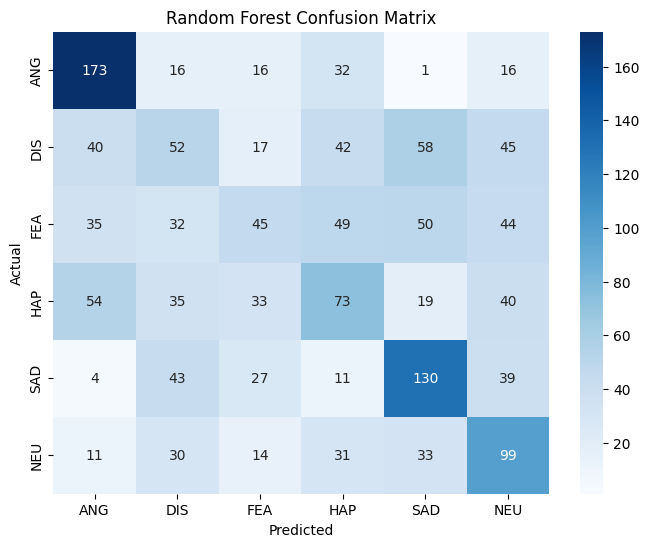

In [183]:
cmrf2 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cmrf2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [184]:
nb_model2 = GaussianNB()
nb_model2.fit(X_train, y_train)

y_pred = nb_model2.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("classification report:\n", classification_report(y_test, y_pred))

accuracy: 0.20953660174613833
classification report:
               precision    recall  f1-score   support

           0       0.41      0.11      0.17       254
           1       0.36      0.02      0.03       254
           2       0.16      0.04      0.06       255
           3       0.27      0.03      0.06       254
           4       0.42      0.17      0.25       254
           5       0.18      1.00      0.31       218

    accuracy                           0.21      1489
   macro avg       0.30      0.23      0.15      1489
weighted avg       0.30      0.21      0.14      1489



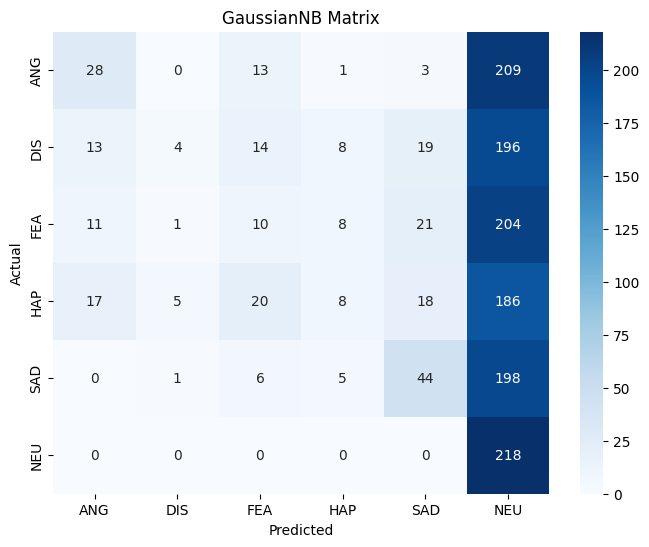

In [185]:
cmnb2 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cmnb2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("GaussianNB Matrix")
plt.show()

Epoch 1/50


c:\Users\milic\OneDrive\Radna površina\faksic\IV_godinica\ML\voice_emotion_recognition\voice_emotion_recognition\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2526 - loss: 1.7282 - val_accuracy: 0.3613 - val_loss: 1.5314
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3199 - loss: 1.5699 - val_accuracy: 0.3808 - val_loss: 1.4990
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3576 - loss: 1.5378 - val_accuracy: 0.3828 - val_loss: 1.5014
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3620 - loss: 1.5165 - val_accuracy: 0.3868 - val_loss: 1.4852
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3631 - loss: 1.5288 - val_accuracy: 0.3956 - val_loss: 1.4825
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3734 - loss: 1.4972 - val_accuracy: 0.3842 - val_loss: 1.4862
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3761 - loss: 1.4887 - val_accuracy: 0.3848 - val_loss: 1.4789
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3649 - loss: 1.4850 - val_accuracy: 0.3936 - val_

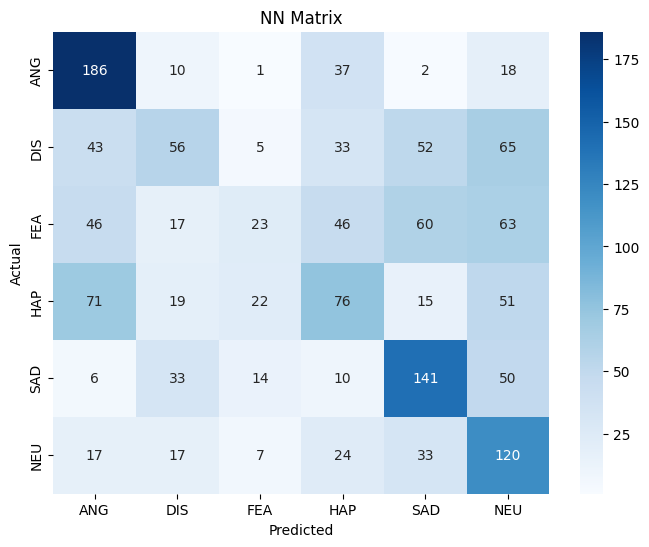

In [186]:
input_dim = X_train.shape[1]  

model2 = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  
])


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model2.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=50, batch_size=32, callbacks=[early_stop],
          class_weight=class_weights)


history = model2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nclassification report:\n")
print(classification_report(y_test, y_pred_classes))


cmnn2 = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cmnn2, annot=True, fmt="d", cmap="Blues",
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("NN Matrix")
plt.show()


Accuracy: 0.3760913364674278
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       254
           1       0.26      0.11      0.16       254
           2       0.26      0.13      0.17       255
           3       0.32      0.31      0.32       254
           4       0.42      0.59      0.49       254
           5       0.31      0.42      0.36       218

    accuracy                           0.38      1489
   macro avg       0.35      0.38      0.35      1489
weighted avg       0.35      0.38      0.35      1489



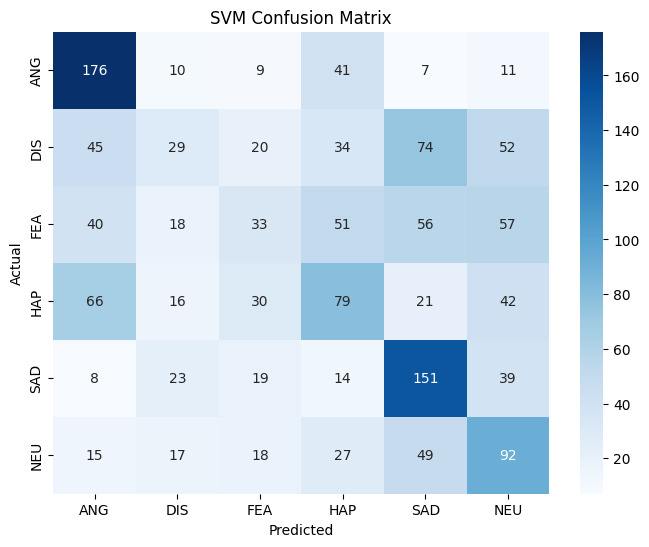

In [187]:
svm_model2 = SVC(kernel='rbf', C=15, gamma=0.001)
svm_model2.fit(X_train, y_train)

y_pred_svm = svm_model2.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

cmsvc2 = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cmsvc2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

accuraccy LDA: 0.37273337810611146
              precision    recall  f1-score   support

           0       0.53      0.65      0.59       254
           1       0.30      0.19      0.23       254
           2       0.26      0.24      0.25       255
           3       0.31      0.22      0.26       254
           4       0.41      0.61      0.49       254
           5       0.33      0.32      0.32       218

    accuracy                           0.37      1489
   macro avg       0.35      0.37      0.36      1489
weighted avg       0.36      0.37      0.36      1489



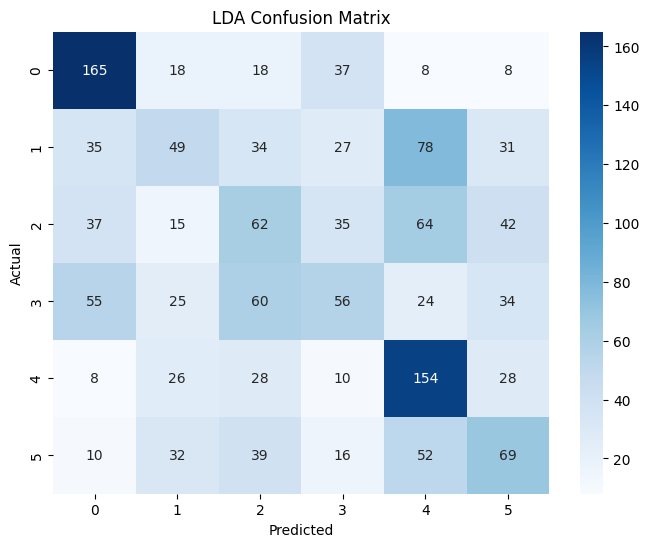

In [188]:
lda_model2 = LinearDiscriminantAnalysis()
lda_model2.fit(X_train, y_train)

y_pred_lda = lda_model2.predict(X_test)

print("accuraccy LDA:", accuracy_score(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda))

cmlda2 = confusion_matrix(y_test, y_pred_lda)
plt.figure(figsize=(8,6))
sns.heatmap(cmlda2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LDA Confusion Matrix')
plt.show()

Comparing results

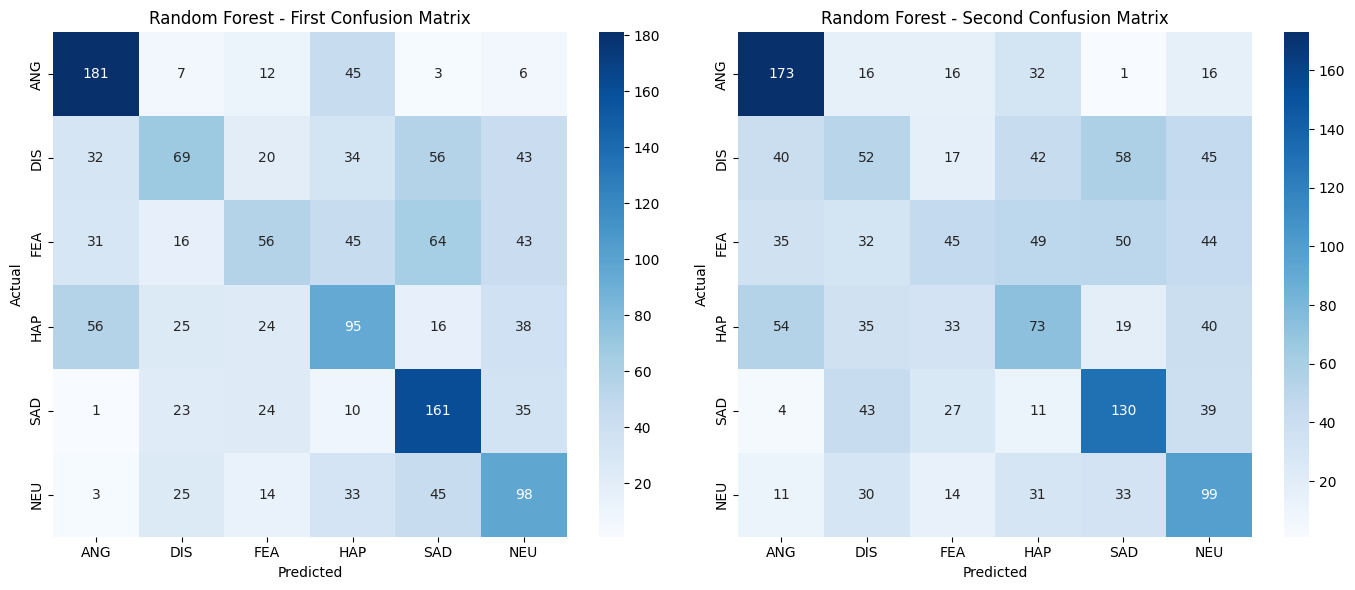

In [189]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmrf1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Random Forest - First Confusion Matrix")

sns.heatmap(cmrf2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("Random Forest - Second Confusion Matrix")

plt.tight_layout()
plt.show()


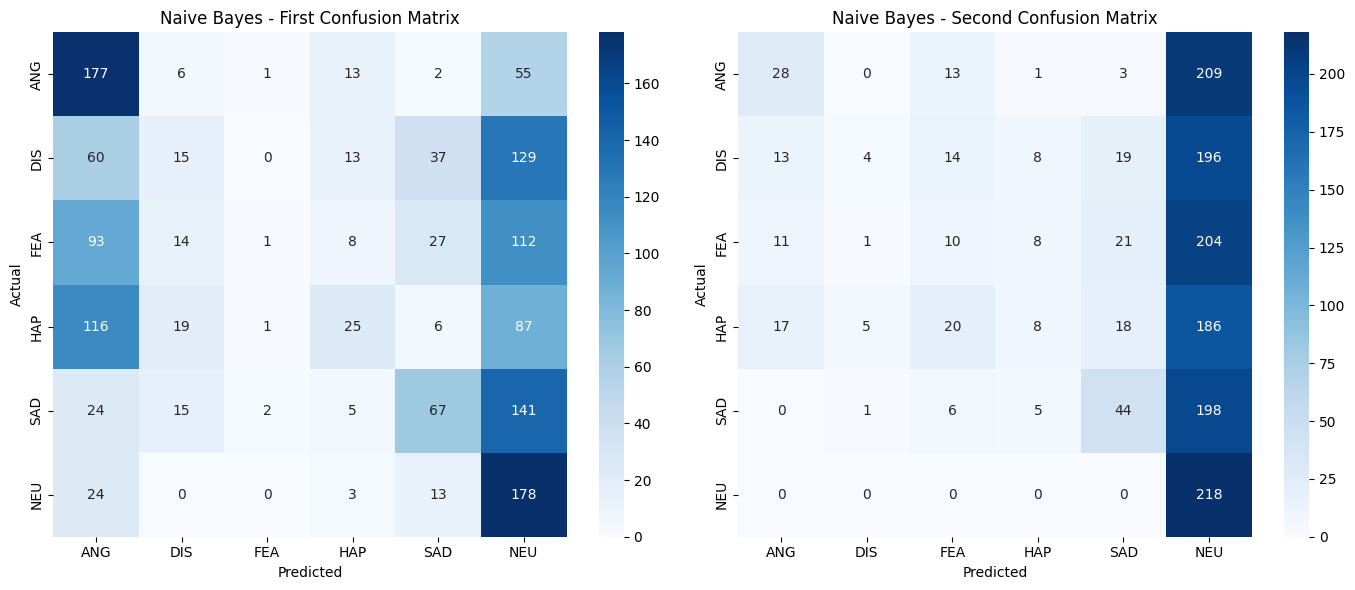

In [190]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmnb1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Naive Bayes - First Confusion Matrix")

sns.heatmap(cmnb2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("Naive Bayes - Second Confusion Matrix")

plt.tight_layout()
plt.show()

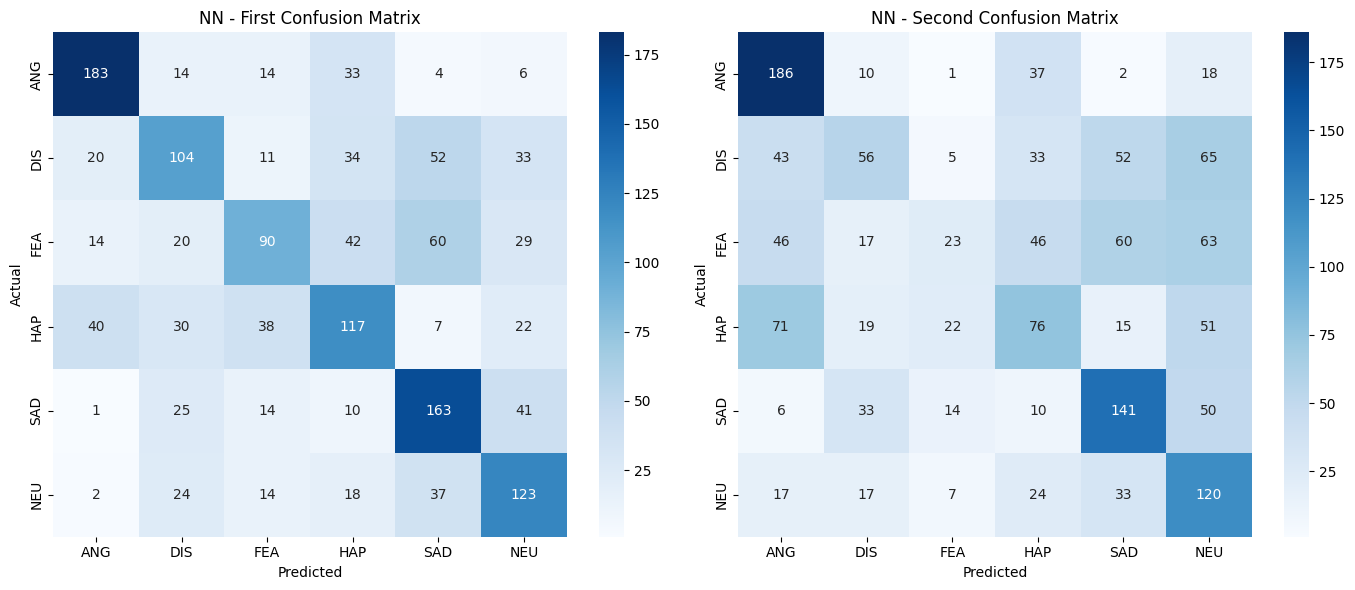

In [191]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmnn1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("NN - First Confusion Matrix")

sns.heatmap(cmnn2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("NN - Second Confusion Matrix")

plt.tight_layout()
plt.show()

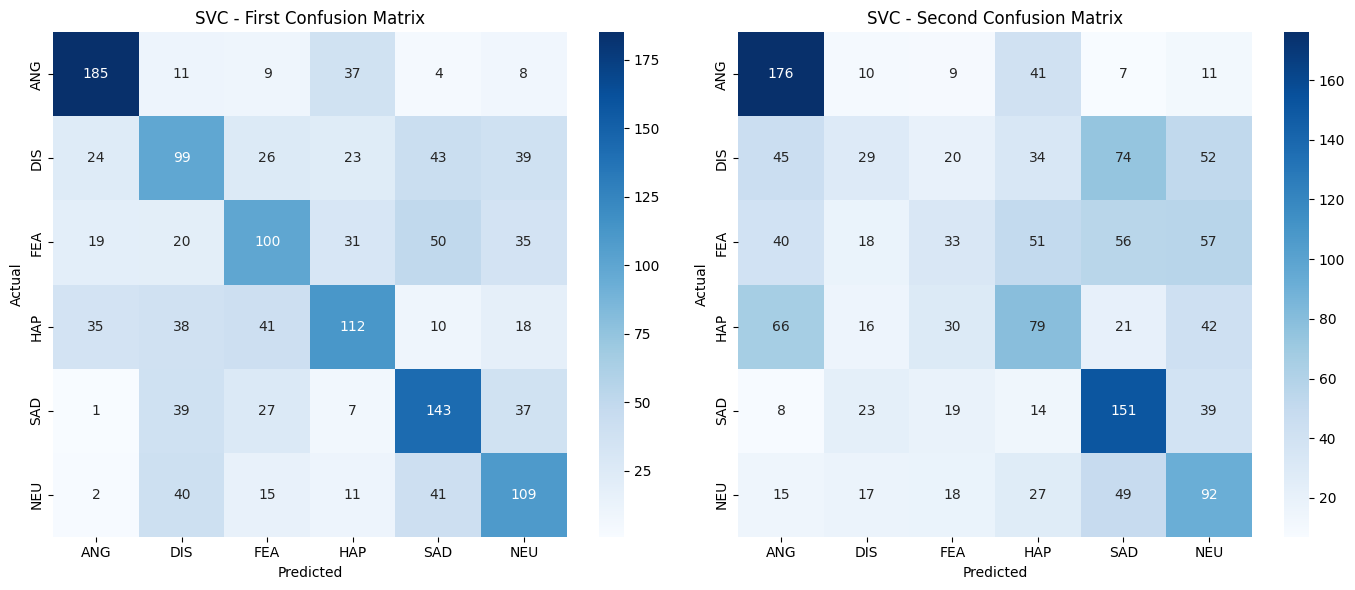

In [192]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmsvc1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("SVC - First Confusion Matrix")

sns.heatmap(cmsvc2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("SVC - Second Confusion Matrix")

plt.tight_layout()
plt.show()

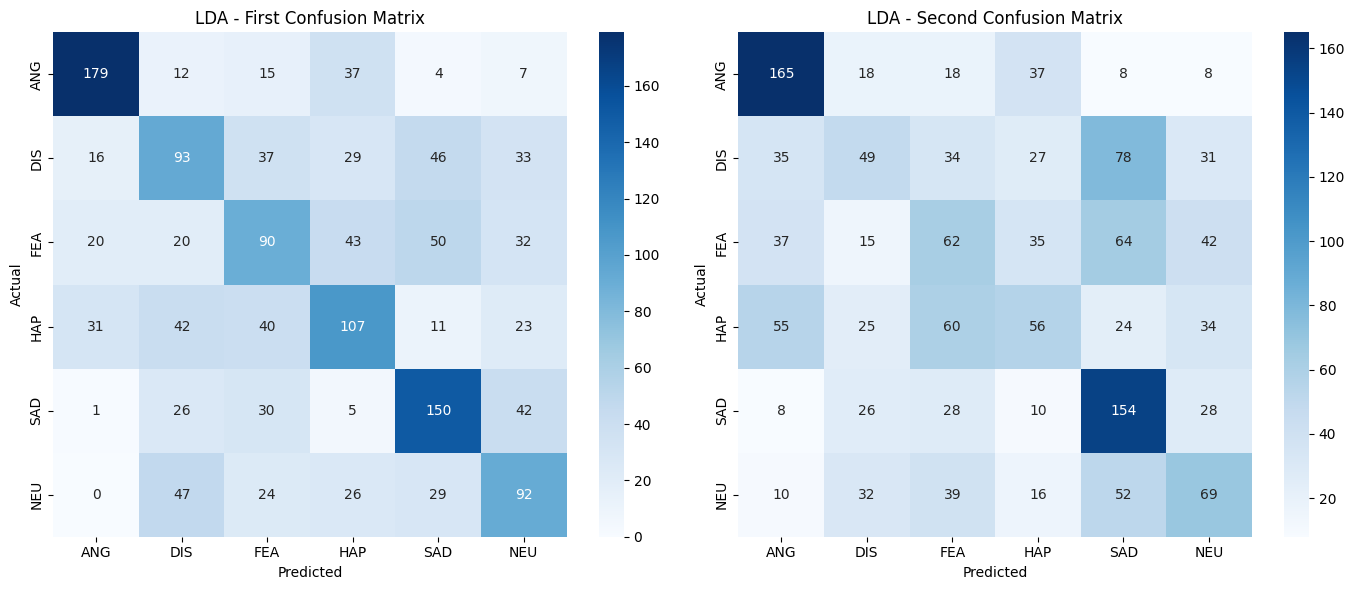

In [193]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmlda1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("LDA - First Confusion Matrix")

sns.heatmap(cmlda2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("LDA - Second Confusion Matrix")

plt.tight_layout()
plt.show()

Finding optimal parameters for the updated dataset

In [194]:
param_grid = {
    'n_estimators': [100, 150, 200, 220, 250, 270, 300, 305, 310, 320],
}

rf2opt = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf2opt,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_rf2opt = grid_search.best_estimator_
y_pred = best_rf2opt.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best parameters: {'n_estimators': 250}
Best cross-validation score: 0.3679453040662109
Test Accuracy: 0.3875083948959033


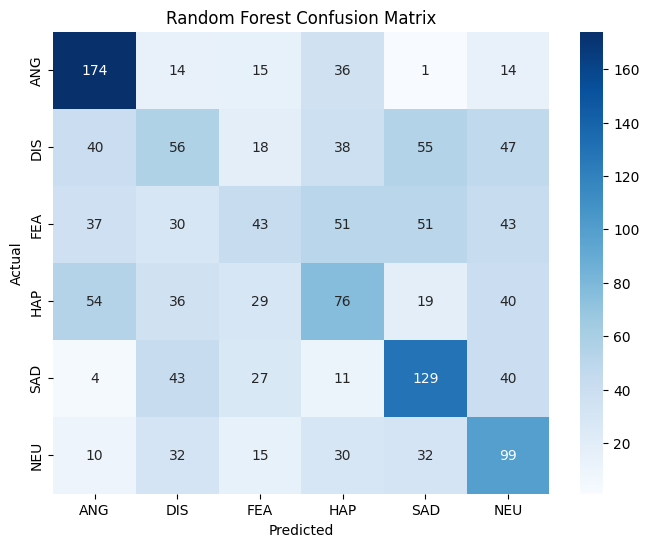

In [195]:
cmrf2opt = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cmrf2opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

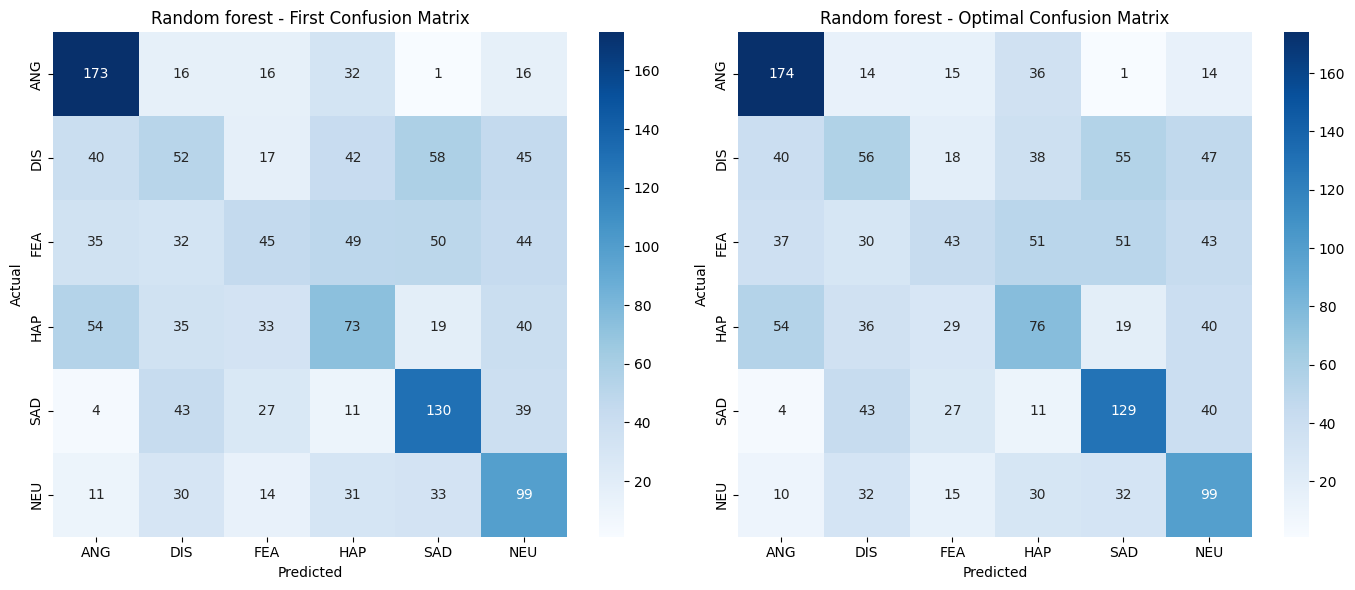

In [196]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmrf2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Random forest - First Confusion Matrix")

sns.heatmap(cmrf2opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("Random forest - Optimal Confusion Matrix")

plt.tight_layout()
plt.show()

Best parameters: {'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.3817251232986897
Test Accuracy: 0.4016118200134318
              precision    recall  f1-score   support

           0       0.52      0.72      0.61       254
           1       0.35      0.19      0.25       254
           2       0.29      0.16      0.21       255
           3       0.34      0.30      0.32       254
           4       0.44      0.57      0.50       254
           5       0.34      0.47      0.39       218

    accuracy                           0.40      1489
   macro avg       0.38      0.40      0.38      1489
weighted avg       0.38      0.40      0.38      1489



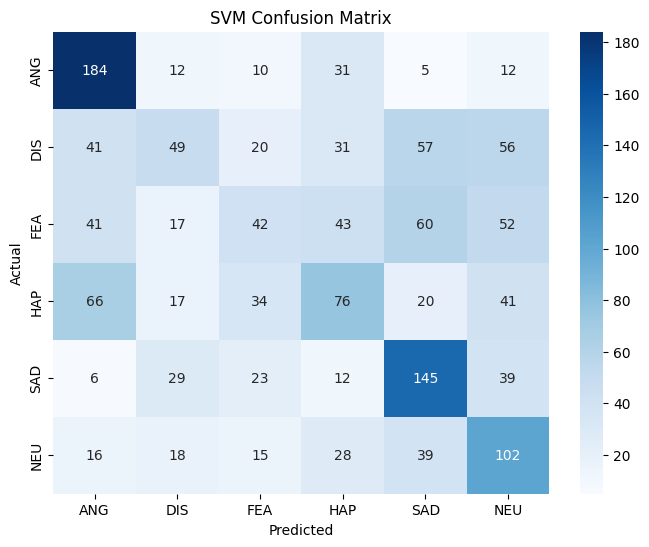

In [197]:
param_grid = {
    'C': [0.1, 1, 5, 10, 15],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']  
}

svc2opt = SVC()

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_svc2opt = grid_search.best_estimator_
y_pred_svm = best_svc2opt.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

cmsvc2opt = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cmsvc2opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

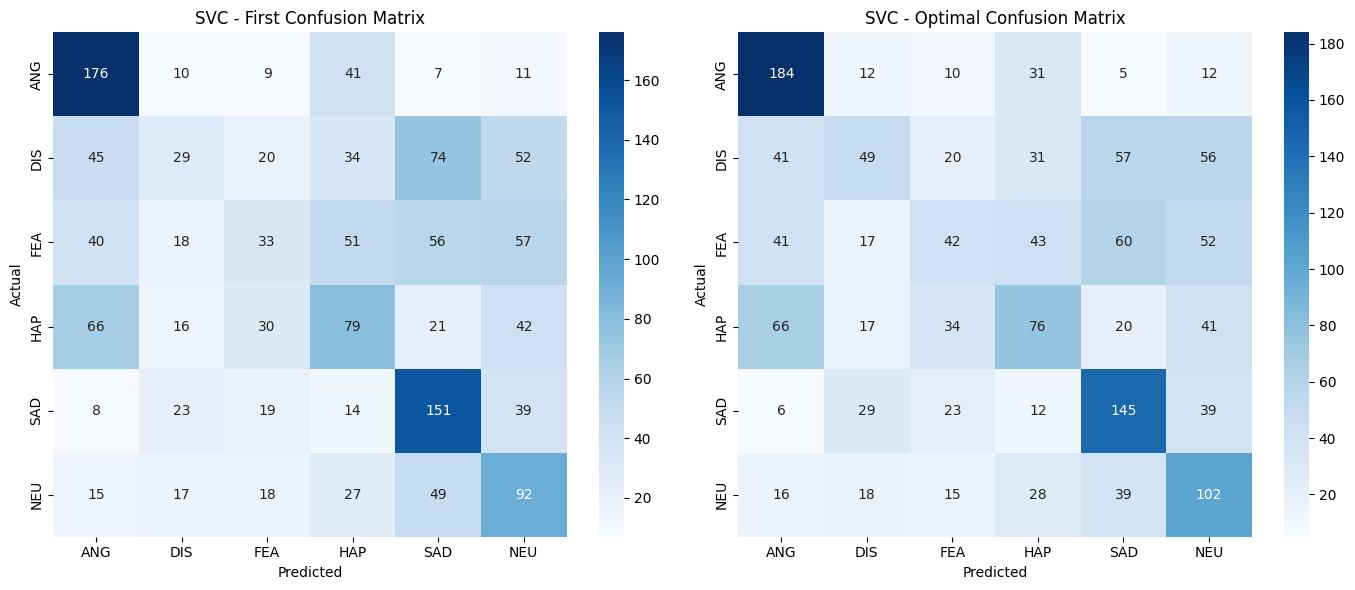

In [199]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmsvc2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("SVC - First Confusion Matrix")

sns.heatmap(cmsvc2opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("SVC - Optimal Confusion Matrix")

plt.tight_layout()
plt.show()

balancing emotion levels data

In [200]:
df = pd.read_csv('../../dataset/features.csv')

idx = df[df['Emotion levels'] == "X"].index
print(idx)

df = df.drop(idx)

df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
df['Emotion levels'] = df['Emotion levels'].apply(lambda x: 0 if x == 'XX' else 1)                  #specified/unspecified


emotion_mapping = {
    'ANG': 0,
    'DIS': 1,
    'FEA': 2,
    'HAP': 3,
    'SAD': 4,
    'NEU': 5
}

df['emotion_numeric'] = df['Emotion'].map(emotion_mapping)

df = df.drop(columns=['Emotion'])

list_columns = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mel_spec_db_mean']

for col in list_columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


for col in list_columns:
    df[col] = df[col].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else 0)


numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

numeric_cols = numeric_cols.drop('emotion_numeric') if 'emotion_numeric' in numeric_cols else numeric_cols

print("cols for standardization:", list(numeric_cols))

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("\ndata after the standardization process:")
print(df[numeric_cols].head())

df = df.drop(columns=['Location'])

Index([3212], dtype='int64')
cols for standardization: ['Gender', 'Age', 'Emotion levels', 'mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mel_spec_db_mean', 'spectral_centroid_mean', 'zcr_mean']

data after the standardization process:
     Gender       Age  Emotion levels  mfcc_mean  mfcc_delta_mean  \
0  0.945445  1.102698       -0.473977  -1.343910         2.993967   
1  0.945445  1.102698       -0.473977  -1.816883        -0.227654   
2  0.945445  1.102698       -0.473977  -1.760424         0.510616   
3  0.945445  1.102698       -0.473977  -1.652316        -0.769750   
4  0.945445  1.102698       -0.473977  -1.269239         0.743748   

   mfcc_delta2_mean  mel_spec_db_mean  spectral_centroid_mean  zcr_mean  
0         -3.426461         -0.557317                0.491062  0.725741  
1         -0.412230          0.789949                0.260493  0.242048  
2          0.022484         -1.363802                0.119985 -0.024465  
3          1.202826         -0.677227          

Epoch 1/50


c:\Users\milic\OneDrive\Radna površina\faksic\IV_godinica\ML\voice_emotion_recognition\voice_emotion_recognition\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2580 - loss: 1.7261 - val_accuracy: 0.3600 - val_loss: 1.5414
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3456 - loss: 1.5812 - val_accuracy: 0.3855 - val_loss: 1.5085
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3555 - loss: 1.5392 - val_accuracy: 0.3868 - val_loss: 1.4968
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3678 - loss: 1.5235 - val_accuracy: 0.3915 - val_loss: 1.4775
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3636 - loss: 1.5056 - val_accuracy: 0.3936 - val_loss: 1.4847
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3745 - loss: 1.4924 - val_accuracy: 0.3882 - val_loss: 1.4711
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3809 - loss: 1.4799 - val_accuracy: 0.3895 - val_loss: 1.4772
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3764 - loss: 1.4874 - val_accuracy: 0.4003 - val_

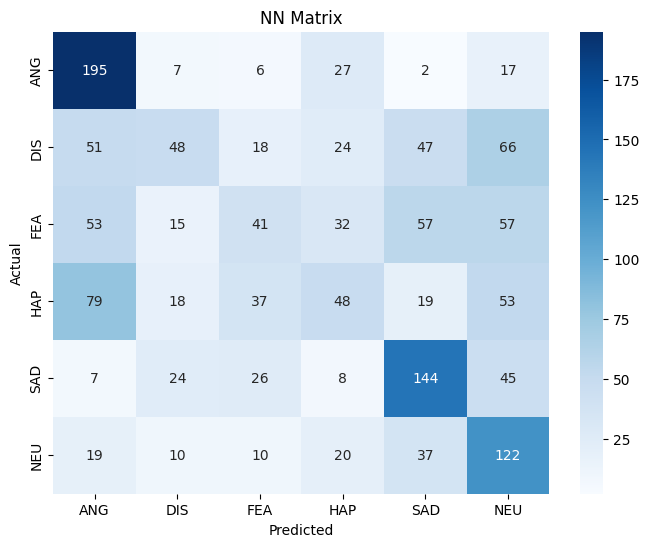

In [201]:
input_dim = X_train.shape[1]  

model3 = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  
])


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model3.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=50, batch_size=32, callbacks=[early_stop],
          class_weight=class_weights)


history = model3.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nclassification report:\n")
print(classification_report(y_test, y_pred_classes))


cmnn3 = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cmnn3, annot=True, fmt="d", cmap="Blues",
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("NN Matrix")
plt.show()


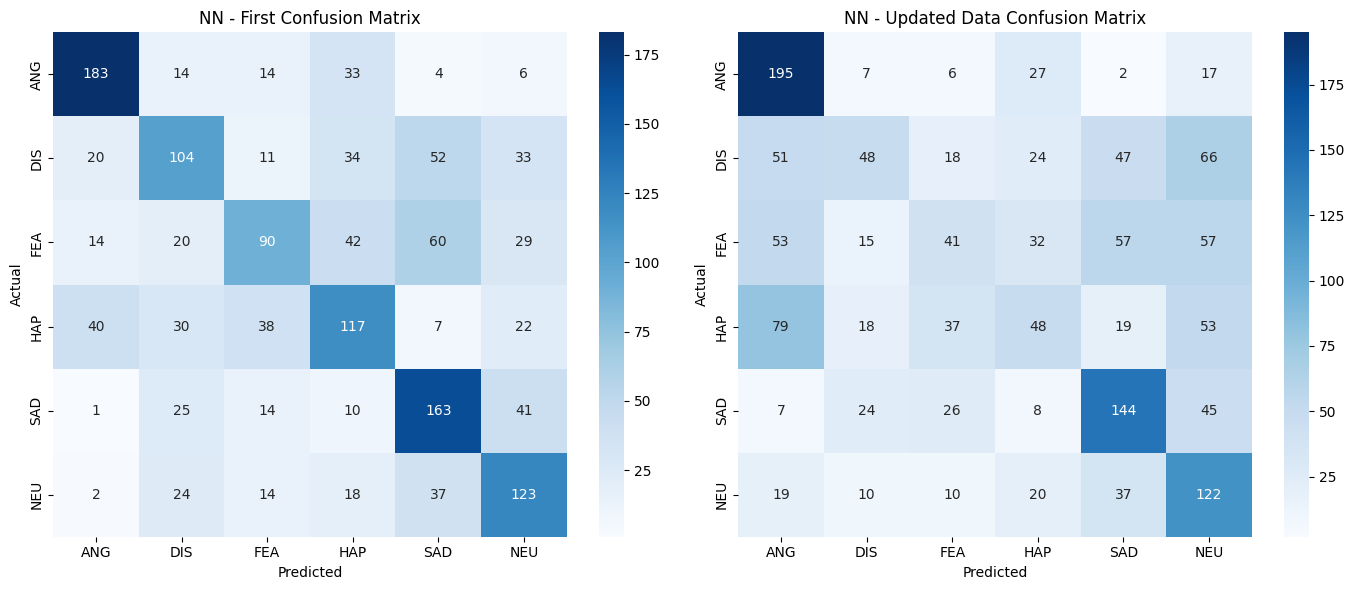

In [202]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cmnn1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("NN - First Confusion Matrix")

sns.heatmap(cmnn3, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            yticklabels=['ANG','DIS','FEA','HAP','SAD','NEU'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("NN - Updated Data Confusion Matrix")

plt.tight_layout()
plt.show()